# DAGs

Using the dag we craeted (not shown here), we determined that by controlling for parental income and GPA
we can get a causal effect of SAT scores on acceptance.

Let's create a simple logistic regression to see what we find.

\begin{align*}
    y &\sim \rm bernoulli \rm logit(\eta) \\
    \alpha &\sim \rm student\text{-}t(\alpha_{\rm df}, \alpha_{\rm loc}, \alpha_{\rm scale}) \\
    \beta &\sim \rm student\text{-}t(\beta_{\rm df}, \beta_{\rm loc}, \beta_{\rm scale}) \\
    \eta &= \alpha + X \beta \\
\end{align*}

For our causal inference model based on income, gpa, and SAT scores we have
\begin{align*}
    y &\sim \rm bernoulli \rm logit(\eta) \\
    \alpha &\sim \rm student\text{-}t(2, 0, 5) \\
    \beta &\sim \rm student\text{-}t(2, 0, 5) \\
    \eta &= \alpha + X \beta \\
\end{align*}

In [2]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from psis import *

import stan
import nest_asyncio
nest_asyncio.apply()

In [32]:
df1 = pd.read_csv("../data/01-raw/test_scores.csv")
df2 = pd.read_csv("../data/02-processed/normalized_data.csv")
df = pd.merge(df2, df1[["SUBJID", "State"]], how='left', on="SUBJID")
df.dropna(inplace=True)
df

,SUBJID,SATMath,SATWriting,SATVerbal,GPA,state,gender,race,income,choice,accepted,school,numapply,habits,SAT,State
0,884230,-1.652536,-1.777725,-1.719744,-0.688423,AL,Female,Black,4.439333,4.0,1.0,2192.0,9,6,-1.918234,AL
1,884232,-1.845287,-1.681540,-1.324951,-2.113622,AL,Male,Black,4.243038,1.0,1.0,2192.0,6,6,-1.809764,AL
2,884233,-1.845287,-2.739570,-2.805425,-3.776353,AL,Male,Black,4.653213,4.0,0.0,2192.0,4,4,-2.749835,AL
3,884247,-0.592404,-0.623510,-0.239270,0.974309,AL,Female,Black,4.096910,1.0,1.0,2192.0,9,8,-0.544284,AL
4,884307,-0.977906,-0.334957,-0.930158,-0.688423,AL,Male,Black,4.096910,4.0,1.0,2192.0,9,7,-0.833536,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91259,886635,-3.098170,-1.008248,-2.015839,0.261710,FL,Female,Two or more race/ethnicity,5.397940,1.0,1.0,1691.0,6,5,-2.279800,FL
91260,886640,0.467728,0.530704,0.451618,0.261710,FL,Female,White,4.942008,1.0,1.0,1691.0,3,7,0.540414,FL
91261,886642,-0.110526,1.684918,1.339902,0.974309,FL,Female,Two or more race/ethnicity,4.829304,1.0,1.0,1691.0,9,6,1.082762,FL
91262,886648,-0.399653,-0.912064,-0.535365,-0.688423,FL,Male,White,4.829304,2.0,1.0,1691.0,6,7,-0.688910,FL


In [33]:
feature_cols = ["SAT", "GPA", "income"]
outcome_col = ["accepted"]

# Get dummy variables for school
df["school"] = df["school"].astype(np.int64)
dummy_school = pd.get_dummies(df["school"], prefix="school")
dummy_state = pd.get_dummies(df["State"], prefix="", prefix_sep="")
dummy_race = pd.get_dummies(df["race"], prefix="", prefix_sep="")
dummy_gender = pd.get_dummies(df["gender"], prefix="", prefix_sep="")
col_labels = feature_cols + list(dummy_school.columns) + list(dummy_state.columns) + list(dummy_race.columns) + list(dummy_gender.columns)
X = pd.concat([df[feature_cols], dummy_school, dummy_state, dummy_race, dummy_gender], axis=1).copy()

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X,
    df[outcome_col],
    train_size=1_000,
    test_size=1_000,
    random_state=17)

In [34]:
# Convert dataframes to np arrays
X_train = X_train_df.copy().to_numpy()
X_test  = X_test_df.copy().to_numpy()
y_train = y_train_df.copy().astype(np.int8).to_numpy().flatten()
y_test = y_test_df.copy().astype(np.int8).to_numpy().flatten()

In [35]:
logistic_regression_code = """
/**
 * Logistic regression t-prior
 *
 * Priors:
 *     weights - student t
 *     intercept - student t
 */
data {
    int n;                        // number of data points
    int d;                        // explanatory variable dimension
    matrix[n, d] X;               // explanatory variable
    array[n] int <lower=0, upper=1> y;  // response variable
    int<lower=1> p_alpha_df;      // prior degrees of freedom for alpha
    real p_alpha_loc;             // prior location for alpha
    real p_alpha_scale;           // prior scale for alpha
    int<lower=1> p_beta_df;       // prior degrees of freedom for beta
    real p_beta_loc;     // prior location for beta
    real p_beta_scale;            // prior scale for beta

    int<lower=0> N_new;
    matrix[N_new, d] X_new;
}
parameters {
    real alpha;      // intercept
    vector[d] beta;  // explanatory variable weights
}
transformed parameters {
    vector[n] eta;  // linear predictor
    eta = alpha + X * beta;
}
model {
    alpha ~ student_t(p_alpha_df, p_alpha_loc, p_alpha_scale);
    beta ~ student_t(p_beta_df, p_beta_loc, p_beta_scale);
    y ~ bernoulli_logit(eta);
}
generated quantities {
    // calculate the log likelihood
    vector[n] log_lik;
    for (i in 1:n)
        log_lik[i] = bernoulli_logit_lpmf(y[i] | eta[i]);

    // generate values for Y tilde
    array[n] int<lower=0, upper=1> Y_tilde;
    Y_tilde = bernoulli_logit_rng(eta);

    // Make predictions
    vector[N_new] y_new;
    for (j in 1:N_new) {
        y_new[j] = bernoulli_logit_rng(alpha + X_new[j] * beta);
    }
}
"""



In [36]:
# Initialize data dictionary

n = X_train.shape[0]
d = X_train.shape[1]
degf = d - 1
data_dict = dict(
    n=n,                # num data points
    d=d,                # num features
    X=X_train,                # data matrix  
    y=y_train,                # response variable
    p_alpha_df=degf,   # prior deg freedom for alpha
    p_alpha_loc=0,      # prior location for alpha
    p_alpha_scale=5,  # prior scale for alpha
    p_beta_df=degf,    # prior deg freedom for beta
    p_beta_loc=0,       # prior location for beta
    p_beta_scale=5,    # prior scale for beta
    N_new=X_test.shape[0],
    X_new=X_test
)

In [37]:
logistic_regression = stan.build(logistic_regression_code, data=data_dict)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [38]:
fit = logistic_regression.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [39]:
fit

<stan.Fit>
Parameters:
    alpha: ()
    beta: (467,)
    eta: (1000,)
    log_lik: (1000,)
    Y_tilde: (1000,)
    y_new: (1000,)
Draws: 4000

In [40]:
az_fit = az.from_pystan(fit)

In [41]:
np.sum(az_fit.sample_stats["diverging"])

<xarray.DataArray 'diverging' ()>
array(0)

In [45]:
summary_table = az.summary(az_fit, var_names=['alpha', 'beta'])
index_labels = ["intercept"] + col_labels
summary_table.index = index_labels
# print(summary_table.to_latex())
summary_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.339,3.144,-3.626,7.994,0.050,0.042,4001.0,3252.0,1.0
SAT,-0.400,0.150,-0.681,-0.119,0.002,0.001,8058.0,3071.0,1.0
GPA,0.070,0.119,-0.152,0.293,0.001,0.002,8751.0,2846.0,1.0
income,-0.315,0.216,-0.700,0.087,0.002,0.002,10007.0,3085.0,1.0
school_2,-0.555,1.421,-3.329,2.043,0.036,0.025,1567.0,2096.0,1.0
...,...,...,...,...,...,...,...,...,...
Other,0.214,1.921,-3.590,3.624,0.042,0.030,2053.0,2550.0,1.0
Two or more race/ethnicity,0.747,1.810,-2.898,3.849,0.041,0.029,1946.0,2325.0,1.0
White,0.772,1.797,-2.807,3.944,0.041,0.029,1945.0,2347.0,1.0
Female,1.179,2.977,-4.354,6.843,0.047,0.045,4074.0,2928.0,1.0


In [57]:
summary_table["mean"].sort_values()

school_313    -6.795
school_1793   -6.407
school_1931   -6.169
school_307    -6.091
school_352    -5.822
               ...  
school_1880    4.089
school_2914    4.257
school_2978    4.282
school_102     5.550
MD             5.746
Name: mean, Length: 468, dtype: float64

In [48]:
school_id = 313
i = school_id
print(f'Original proportion of acceptance : {np.sum(df[df["school"] == i]["accepted"]) / len(df[df["school"] == i])}')

cheat_df = pd.concat([X_train_df, y_train_df], axis=1)
cheat_df.loc[:, [f"school_{i}", "accepted"]][f"school_{i}"].sum()
cheat_df_where = cheat_df.loc[:, [f"school_{i}", "accepted"]]
print(f'training proportion of acceptance : {sum(cheat_df_where[cheat_df_where[f"school_{i}"] == 1]["accepted"])/ cheat_df_where[f"school_{i}"].sum()}')

Original proportion of acceptance : 0.72
training proportion of acceptance : 0.0


As we can see here we have major sampling bias coming into play. 
The only way to resolve this would be to increase the number of samples we feed our model,
but that would be too computationally expensive.

## Interpretation

When controlling for GPA and income, we find that the coefficient for SAT scores is
$-0.272$. Hence, $e^{-0.272}=0.76$ implies that increases in SAT scores result in a 
$24\%$ reduction in odds that a student gets admitted to their top choice school.

At the same time GPA is associated with a $e^{0.094}=1.098$ or roughly $10\%$ increase in 
the odds of getting admitted to their top choice and income is associated with a $4\%$ increase in odds.

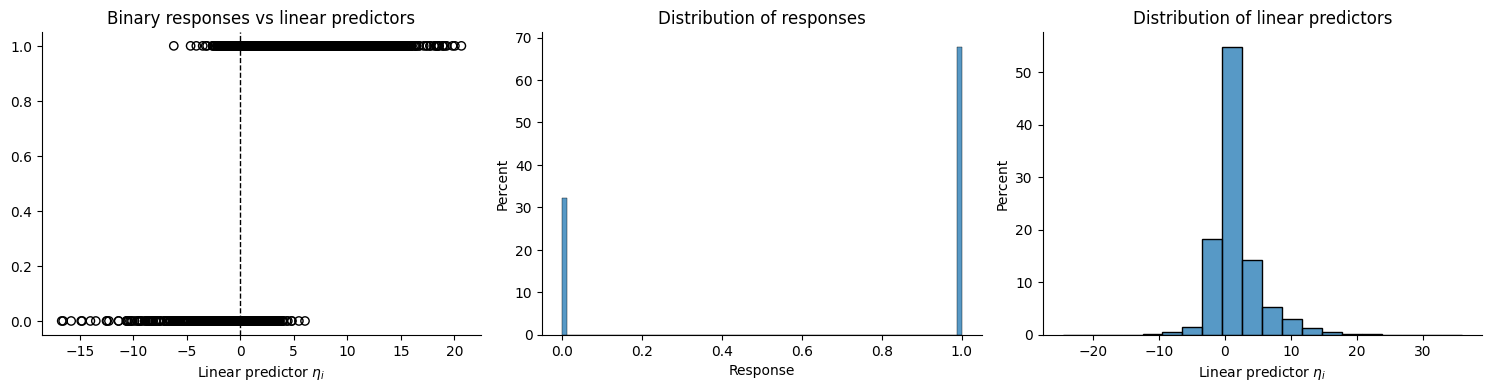

In [52]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  t = np.random.randint(0, 4000)
  plt.scatter(fit['eta'][:, t], fit['Y_tilde'][:, t], c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')


plt.subplot(132)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'].flatten(), bins=20, stat='percent')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

As we can see there doesn't seem to be a large distinction between linear predictors and the actual binary response.
This could be a result of observations that have the same features, but differ in other ways not captured in the data.
It's most likely a reflection that the model is not comprehensive enough to pick up on the distinctions between applicants.

Use pareto smooted importance sampling leave-one-out cross-validation to estimate predictive performance

In [50]:
# Use arviz to compute the loo elpd
az.loo(az_fit, pointwise=True)

/home/mitch/.local/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 1000 log-likelihood matrix

         Estimate       SE
elpd_loo  -653.61    22.95
p_loo      206.08        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      777   77.7%
 (0.5, 0.7]   (ok)        110   11.0%
   (0.7, 1]   (bad)        98    9.8%
   (1, Inf)   (very bad)   15    1.5%

In [ ]:
# az.plot_trace(az_fit, var_names=["alpha", "beta"])
# plt.tight_layout()
# plt.show();

In [51]:
print(classification_report(y_test, fit["y_new"][:, 72]))

              precision    recall  f1-score   support

           0       0.35      0.39      0.37       294
           1       0.73      0.70      0.71       706

    accuracy                           0.61      1000
   macro avg       0.54      0.55      0.54      1000
weighted avg       0.62      0.61      0.61      1000

